In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
andel_avslag=df['Avslag_ind'].sum()/df['Avslag_ind'].count()

In [6]:
andel_avslag

0.030107526881720432

In [7]:
antall_avslag=df['Avslag_ind'].sum()

In [8]:
antall_avslag

28

In [9]:
df["Kurvatur, horisontal"]=df["Kurvatur, horisontalelement"]

In [10]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    #"Kurvatur, horisontalelement", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [11]:
df_encoded=df_encoded.dropna()

In [12]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)

In [13]:
df_encoded['sving'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, df_encoded['Kurvatur, horisontal'].abs(), 0)

In [14]:
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)

In [15]:
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)

In [16]:
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()

In [17]:
df_encoded['bakke_sigmoid'] = 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs()))

In [18]:
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100

In [19]:
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)

In [20]:
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [21]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_A - Nasjonale hovedveger,...,EGS.BRUKSOMRÅDE.1256_Service,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk,EGS.BRUKSOMRÅDE.1256_Skole/Barnehage,sving_ind,sving,bakke_ind,sving_sigmoid,bakke,bakke_sigmoid,antall_lange_kj
0,100.0,10.0,80.0,0,0,True,False,False,False,False,...,False,False,False,1,558.0,1,0.635990,2.7,0.635990,10.0
1,850.0,14.0,50.0,0,4,True,False,False,False,False,...,False,False,False,1,24.0,1,0.506000,8.4,0.506000,119.0
2,800.0,10.0,60.0,0,0,False,False,True,False,False,...,False,False,False,0,0.0,1,0.000000,3.7,1.000000,80.0
3,6400.0,12.0,50.0,0,23,False,True,False,False,False,...,False,False,False,0,0.0,1,0.000000,0.7,1.000000,768.0
4,600.0,14.0,50.0,1,2,True,False,False,False,False,...,False,False,False,0,0.0,1,0.000000,1.8,1.000000,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,1300.0,6.0,30.0,21,0,True,False,False,False,False,...,False,False,False,1,1520.0,1,0.820538,0.5,0.820538,78.0
926,500.0,10.0,60.0,12,2,False,False,True,False,False,...,False,False,False,1,1119.0,1,0.753803,0.2,0.753803,50.0
927,400.0,13.0,60.0,12,0,False,False,False,True,False,...,False,False,False,1,192.0,1,0.547853,5.5,0.547853,52.0
928,1600.0,15.0,80.0,8,6,False,False,False,True,False,...,False,True,False,1,524.0,1,0.628083,3.0,0.628083,240.0


In [22]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=True) 
X = pd.DataFrame(
    poly.fit_transform(X),
    columns=poly.get_feature_names_out(X.columns)
)

In [23]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_A - Nasjonale hovedveger,...,bakke_ind sving_sigmoid bakke,bakke_ind sving_sigmoid bakke_sigmoid,bakke_ind sving_sigmoid antall_lange_kj,bakke_ind bakke bakke_sigmoid,bakke_ind bakke antall_lange_kj,bakke_ind bakke_sigmoid antall_lange_kj,sving_sigmoid bakke bakke_sigmoid,sving_sigmoid bakke antall_lange_kj,sving_sigmoid bakke_sigmoid antall_lange_kj,bakke bakke_sigmoid antall_lange_kj
0,100.0,10.0,80.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.717172,0.404483,6.359897,1.717172,27.0,6.359897,1.092104,17.171721,4.044828,17.171721
1,850.0,14.0,50.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,4.250398,0.256036,60.213966,4.250398,999.6,60.213966,2.150700,505.797312,30.468249,505.797312
2,800.0,10.0,60.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,3.700000,296.0,80.000000,0.000000,0.000000,0.000000,296.000000
3,6400.0,12.0,50.0,0.0,23.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.700000,537.6,768.000000,0.000000,0.000000,0.000000,537.600000
4,600.0,14.0,50.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,1.800000,151.2,84.000000,0.000000,0.000000,0.000000,151.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,1300.0,6.0,30.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.410269,0.673283,64.002001,0.410269,39.0,64.002001,0.336642,32.001001,52.516105,32.001001
852,500.0,10.0,60.0,12.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.150761,0.568219,37.690159,0.150761,10.0,37.690159,0.113644,7.538032,28.410962,7.538032
853,400.0,13.0,60.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,...,3.013192,0.300143,28.488360,3.013192,286.0,28.488360,1.650787,156.685982,15.607436,156.685982
854,1600.0,15.0,80.0,8.0,6.0,0.0,0.0,0.0,1.0,0.0,...,1.884248,0.394488,150.739830,1.884248,720.0,150.739830,1.183463,452.219489,94.677068,452.219489


In [24]:
andel_avslag=y.sum()/y.count()

In [25]:
#X=df_with_interactions
scaler = PowerTransformer()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [26]:
# Identify binary dummy columns: only {0,1} or {0.0,1.0}
binary_cols = [
    col for col in X.columns
    if np.isin(X[col].dropna().unique(), [0,1]).all()
]

continuous_cols = [col for col in X.columns if col not in binary_cols]

# Transform only continuous columns
scaler = PowerTransformer()
X_cont_scaled = pd.DataFrame(
    scaler.fit_transform(X[continuous_cols]),
    columns=continuous_cols,
    index=X.index
)

# Combine back into full feature matrix
X = pd.concat([X_cont_scaled, X[binary_cols]], axis=1)

In [27]:
X

,"ÅDT, total","ÅDT, andel lange kjøretøy",Fartsgrense,Avkjørsler,Trafikkulykker,"Avkjørsel, holdningsklasse_Lite streng","Avkjørsel, holdningsklasse_Meget streng","Avkjørsel, holdningsklasse_Mindre streng","Avkjørsel, holdningsklasse_Streng",Funksjonsklasse_A - Nasjonale hovedveger,...,EGS.BRUKSOMRÅDE.1256_Service EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke,EGS.BRUKSOMRÅDE.1256_Service EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Service EGS.BRUKSOMRÅDE.1256_Skole/Barnehage antall_lange_kj,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_ind,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_ind,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage sving_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage bakke_sigmoid,EGS.BRUKSOMRÅDE.1256_Skog/skogbruk EGS.BRUKSOMRÅDE.1256_Skole/Barnehage antall_lange_kj
0,-1.728914,0.032444,1.100559,-1.501889,-1.078347,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.386362,0.950157,-1.027313,-1.501889,1.076965,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.331628,0.032444,-0.411411,-1.501889,-1.078347,-0.658662,-0.206473,2.023669,-0.501460,-0.034199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.055119,0.535965,-1.027313,-1.501889,1.712847,-0.658662,4.843257,-0.494152,-0.501460,-0.034199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.067903,0.950157,-1.027313,-1.144551,0.672695,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,0.761977,-1.446768,-2.031513,1.439921,-1.078347,1.518229,-0.206473,-0.494152,-0.501460,-0.034199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
852,-0.102736,0.032444,-0.411411,0.591421,0.672695,-0.658662,-0.206473,2.023669,-0.501460,-0.034199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
853,-0.315335,0.752376,-0.411411,0.591421,-1.078347,-0.658662,-0.206473,-0.494152,1.994178,-0.034199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
854,0.940586,1.132024,1.100559,0.115026,1.273576,-0.658662,-0.206473,-0.494152,1.994178,-0.034199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
model = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
importances
# Select top 10 features
top_features = importances_sorted.index[:15]
X_top = X[top_features]

In [29]:
importances_sorted

Fartsgrense bakke bakke_sigmoid                                                            0.006107
bakke bakke_sigmoid                                                                        0.005728
bakke_ind bakke bakke_sigmoid                                                              0.005166
ÅDT, andel lange kjøretøy bakke_ind bakke                                                  0.004719
Fartsgrense Avkjørsler bakke_sigmoid                                                       0.004587
                                                                                             ...   
Avkjørsler Funksjonsklasse_A - Nasjonale hovedveger EGS.BRUKSOMRÅDE.1256_Gardsbruk         0.000000
Avkjørsler Funksjonsklasse_A - Nasjonale hovedveger EGS.BRUKSOMRÅDE.1256_Hytte             0.000000
Avkjørsler Funksjonsklasse_A - Nasjonale hovedveger EGS.BRUKSOMRÅDE.1256_Industri          0.000000
Avkjørsler Funksjonsklasse_A - Nasjonale hovedveger EGS.BRUKSOMRÅDE.1256_Naust             0.000000


In [30]:
X=X_top

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)

In [32]:
X_train_orig=X_train
y_train_orig=y_train

In [33]:
smote = ADASYN(sampling_strategy=0.3, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [34]:
# Fit logistic regression
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [35]:
yps=model.predict_proba(X_test)

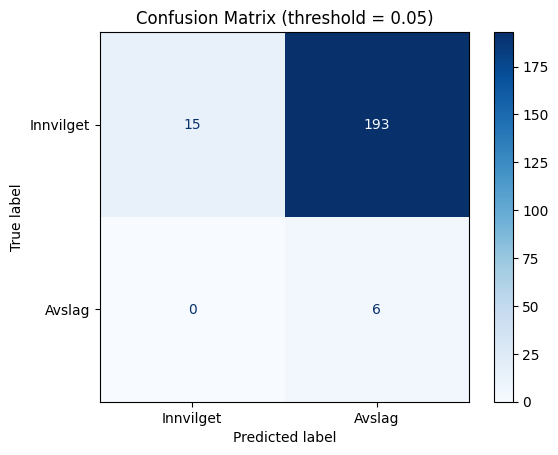

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.05 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [37]:
# Detailed metrics per class
print("Classification Report Logistic regression:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Logistic regression:
              precision    recall  f1-score   support

           0     1.0000    0.0721    0.1345       208
           1     0.0302    1.0000    0.0585         6

    accuracy                         0.0981       214
   macro avg     0.5151    0.5361    0.0965       214
weighted avg     0.9728    0.0981    0.1324       214



In [38]:
model = RandomForestClassifier(n_estimators=5000,n_jobs=-1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5000, n_jobs=-1)

In [39]:
yps=model.predict_proba(X_test)

In [40]:
X_test

,Fartsgrense bakke bakke_sigmoid,bakke bakke_sigmoid,bakke_ind bakke bakke_sigmoid,"ÅDT, andel lange kjøretøy bakke_ind bakke",Fartsgrense Avkjørsler bakke_sigmoid,"ÅDT, andel lange kjøretøy bakke_ind bakke_sigmoid",Fartsgrense bakke,"ÅDT, andel lange kjøretøy Avkjørsel, holdningsklasse_Streng bakke",Fartsgrense bakke_ind bakke,bakke_ind bakke,"ÅDT, total antall_lange_kj","ÅDT, total bakke antall_lange_kj","ÅDT, andel lange kjøretøy Avkjørsler","ÅDT, andel lange kjøretøy bakke bakke_sigmoid","ÅDT, andel lange kjøretøy Fartsgrense Avkjørsler"
509,-1.215142,-1.205206,-1.180299,-0.540008,0.727105,0.916994,-1.114003,2.034171,-1.057615,-1.075659,1.975972,1.445011,2.333028,-0.685066,1.968540
122,-0.639475,-0.326053,-0.325342,-0.426733,-0.057390,0.745700,-0.834510,-0.492315,-0.802401,-0.585818,0.526164,0.247260,0.221511,-0.179828,-0.147702
275,1.179861,1.333586,1.333177,0.870105,-0.943661,0.563904,0.799919,-0.492315,0.784433,0.938758,0.309073,0.624255,-1.017488,1.243274,-0.950555
11,0.852306,1.005452,1.000409,1.610394,-1.572869,-0.157278,1.283557,-0.492315,1.278912,1.434818,1.022982,1.517011,-1.575952,1.156730,-1.632105
506,-1.761752,-1.649240,-1.789335,-1.985321,1.446218,-2.449534,-1.826922,1.967847,-2.035126,-1.790900,1.560556,0.212456,0.938489,-1.784435,0.655336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720,-0.812582,-1.084286,-1.063585,-0.426733,0.514584,1.712874,-0.834510,-0.492315,-0.802401,-1.075659,0.960931,0.366051,1.160533,-0.398826,1.554669
464,1.327040,1.092898,1.088850,-0.268728,0.512101,-0.801751,0.933868,2.034779,0.920417,0.702026,2.108669,2.587880,-0.586817,0.000827,-0.425842
249,0.710150,0.495186,0.487735,0.039385,1.948030,0.372625,0.374106,-0.492315,0.357464,0.137691,-0.070040,0.023421,0.819883,0.347251,1.150264
801,-0.924690,-1.012001,-0.993684,-0.710328,0.088998,-0.602273,-0.684454,-0.492315,-0.663139,-0.732908,0.945732,0.564608,0.423776,-0.981730,0.371139


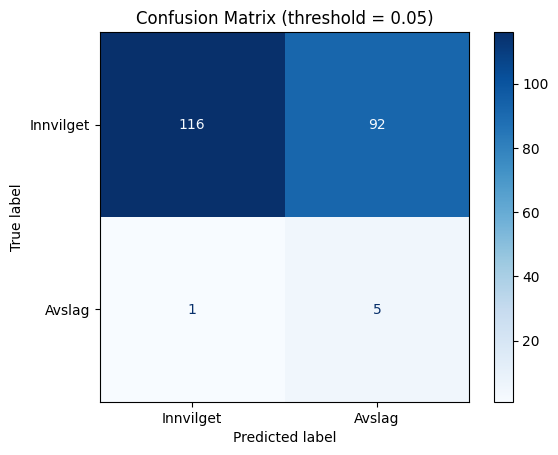

In [41]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicted probabilities for class "1"
y_prob = yps[:, 1]

# Adjustable threshold
threshold = 0.05 # 👈 change this value between 0 and 1

# Convert probabilities to class predictions
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Innvilget", "Avslag"])

# Plot
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.show()

In [42]:
# Detailed metrics per class
print("Classification Report Random Forrest:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report Random Forrest:
              precision    recall  f1-score   support

           0     0.9915    0.5577    0.7138       208
           1     0.0515    0.8333    0.0971         6

    accuracy                         0.5654       214
   macro avg     0.5215    0.6955    0.4055       214
weighted avg     0.9651    0.5654    0.6966       214



In [43]:
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances_sorted = importances.sort_values(ascending=False)

In [44]:
print(importances_sorted)

ÅDT, andel lange kjøretøy Avkjørsel, holdningsklasse_Streng bakke    0.110971
Fartsgrense Avkjørsler bakke_sigmoid                                 0.087533
ÅDT, total bakke antall_lange_kj                                     0.083921
ÅDT, total antall_lange_kj                                           0.074238
ÅDT, andel lange kjøretøy Avkjørsler                                 0.071188
ÅDT, andel lange kjøretøy Fartsgrense Avkjørsler                     0.070679
ÅDT, andel lange kjøretøy bakke_ind bakke                            0.059734
Fartsgrense bakke bakke_sigmoid                                      0.059318
Fartsgrense bakke                                                    0.059196
ÅDT, andel lange kjøretøy bakke_ind bakke_sigmoid                    0.058287
Fartsgrense bakke_ind bakke                                          0.056923
ÅDT, andel lange kjøretøy bakke bakke_sigmoid                        0.053839
bakke bakke_sigmoid                                             

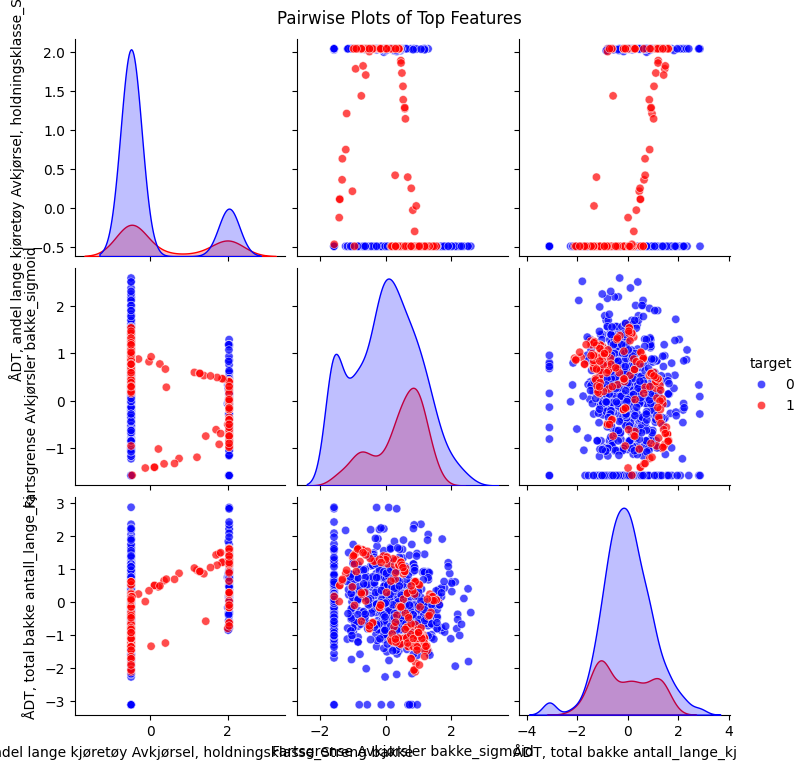

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the top 4 features
top_features = importances_sorted.index[:3]

# Subset data
X_top = X_train[top_features].copy()
X_top['target'] = y_train  # add the target

# Pairwise scatter plots
sns.pairplot(
    X_top,
    vars=top_features,
    hue='target',            # color by target
    palette={0: "blue", 1: "red"}, 
    plot_kws={'alpha': 0.7}
)
plt.suptitle("Pairwise Plots of Top Features", y=1.02)
plt.show()

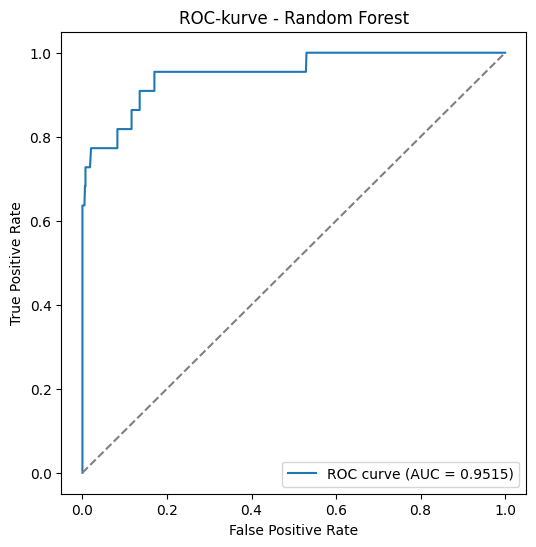

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Sannsynligheter for den positive klassen
y_proba = model.predict_proba(X)[:, 1]

# Beregn ROC-verdier
fpr, tpr, thresholds = roc_curve(y, y_proba)
auc = roc_auc_score(y, y_proba)

# Plott ROC-kurve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-kurve - Random Forest')
plt.legend(loc='lower right')
plt.show()

In [47]:
#Kort sagt: hver x-verdi viser hvor mange negative som blir feil, hver y-verdi viser hvor mange positive som blir riktig.

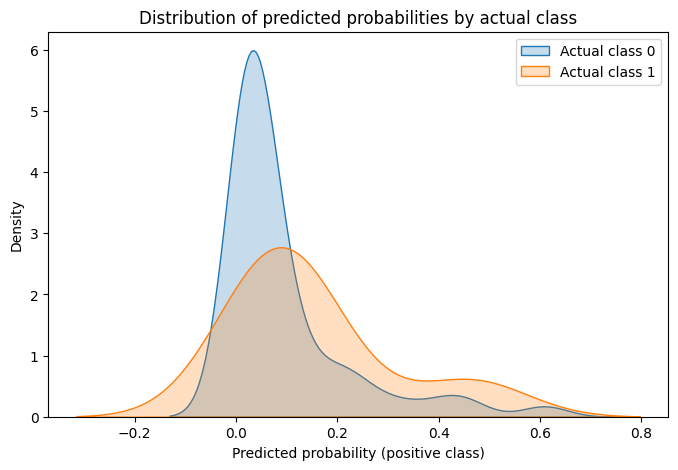

In [48]:
y_proba = yps[:, 1]

# Combine into one DataFrame for easy plotting
import pandas as pd
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [49]:
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=1000,sampling_strategy=0.3,
                              random_state=42, n_jobs=-1)
model.fit(X_train_orig, y_train_orig)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

C:\Users\jens.nilsen\python\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\jens.nilsen\python\WPy64-31241\python-3.12.4.amd64\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


In [50]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9704    0.9471    0.9586       208
           1     0.0000    0.0000    0.0000         6

    accuracy                         0.9206       214
   macro avg     0.4852    0.4736    0.4793       214
weighted avg     0.9432    0.9206    0.9318       214



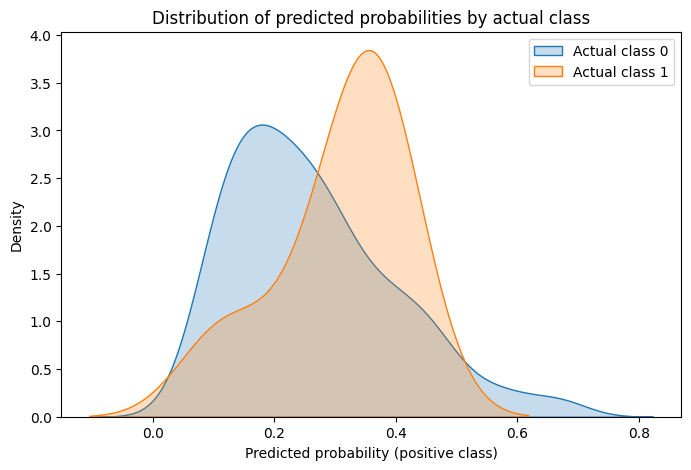

In [51]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [52]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np

# Calculate imbalance ratio
pos = np.sum(y_train_orig == 1)
neg = np.sum(y_train_orig == 0)
scale_pos_weight = neg / pos  # also try tuning around this

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  
    n_jobs=-1,
    random_state=42,
    tree_method="hist",    # fast modern tree builder
)

param_distributions = {
    "n_estimators": randint(50, 5000),
    "learning_rate": uniform(0.001, 1.0),
    "max_depth": randint(3, 15),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.1, 0.9),
    "gamma": uniform(0, 5),
    "reg_alpha": uniform(0, 5),
    "reg_lambda": uniform(0, 5),
    "scale_pos_weight": uniform(scale_pos_weight*0.5, scale_pos_weight*1.5)
}

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_distributions,
    n_iter=100,                    # increase to 150 if you have time
    scoring="f1_macro",
    cv=4,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train_orig, y_train_orig)

print("Best score:", search.best_score_)
print("Best params:", search.best_params_)

model = search.best_estimator_


Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best score: 0.5097238713256383
Best params: {'colsample_bytree': 0.3681635063877554, 'gamma': 2.618011380075056, 'learning_rate': 0.6986418714934634, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 3522, 'reg_alpha': 2.460581465397691, 'reg_lambda': 1.2912219414947916, 'scale_pos_weight': 46.50802969423296, 'subsample': 0.9920130301141908}


In [53]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

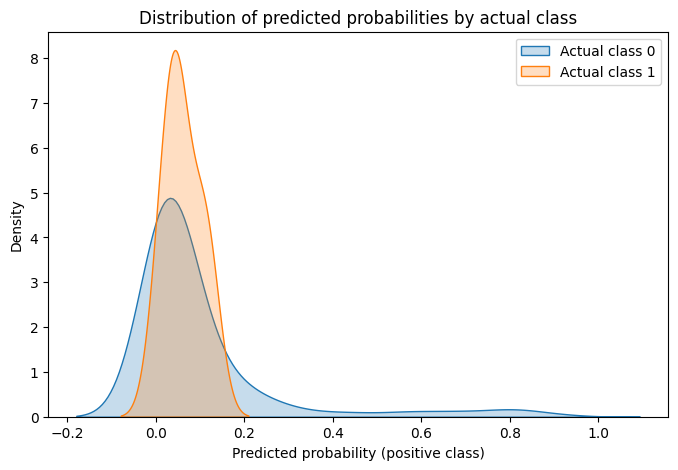

In [54]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()